# Twitter Sentiment Analysis

In [1]:
!pip install gensim 
!pip install keras --upgrade
!pip install keras.preprocessing 
!pip install keras.models
!pip install tensorflow
!pip install Word2Vec
!pip install pandas --upgrade

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.4
    Uninstalling colorama-0.4.4:
      Successfully uninstalled colorama-0.4.4


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439795 sha256=99256b5c431c569fc3146d00ba52e3b30d1b939562ffae1f18b3707eeddcce50
  Stored in directory: c:\users\okazm\appdata\local\pip\cache\wheels\05\94\dc\81042da9bced43ff430bc02043d213d9e4b210b584c39e31c1
Successfully built jax
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.
mysql-connector-python 8.0.31 requires protobuf<=3.20.1,>=3.11.0, but you have protobuf 4.23.0 which is incompatible.
mediapipe 0.8.3 requires numpy==1.19.3, but you have numpy 1.22.4 which is incompatible.


      Successfully uninstalled protobuf-3.19.4
  Installing build dependencies: started


  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
Failed to build Word2Vec



  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\okazm\anaconda3\python.exe' 'C:\Users\okazm\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\okazm\AppData\Local\Temp\tmpp7cguh8z'
       cwd: C:\Users\okazm\AppData\Local\Temp\pip-install-u37vkydu\word2vec_3996e605d3ec426fbe25755002ad1569
  Complete output (130 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\word2vec
  copying word2vec\io.py -> build\lib\word2vec
  copying word2vec\scripts_interface.py -> build\lib\word2vec
  copying word2vec\utils.py -> build\lib\word2vec
  copying word2vec\wordclusters.py -> build\lib\word2vec
  copying word2vec\wordvectors.py -> build\lib\word2vec
  copying word2vec\_generated_version.py -> build\lib\word2vec
  copying word2vec\__init__.py -> build\lib\word2vec
  creating build\lib\word2vec\tests
  copying word2vec\tests\test_core.py -> build\lib\word2vec\t

  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4


In [55]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [56]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\okazm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [57]:
# Датасет
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# Чистка текста
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# Окраска
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# экспорт
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Описание датасета
* **target**: характеристика твита (0 = negative, 4 = positive)
* **ids**: id 
* **date**: дата
* **flag**: флаг (везде определен как NO_QUERY)
* **user**: пользователь 
* **text**: текст твита

In [61]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

dataset_path = 'tweets.csv'

df = pd.read_csv(dataset_path, encoding = DATASET_ENCODING , names = DATASET_COLUMNS)

# Перемешиваем и сокращаем датасет, так как нет достаточных мощностей
df = shuffle(df)
df = df.iloc[:400000]

# Проверяем что нет большой разницы в значениях
pd.DataFrame(df.target.value_counts())

,count
target,
4,200063
0,199937


In [62]:
print("Dataset size:", len(df))

Dataset size: 400000


In [63]:
df.head(5)

,target,ids,date,flag,user,text
175912,0,1965069250,Fri May 29 15:16:44 PDT 2009,NO_QUERY,Soph4Soph,@Juicytots yay!! we'll all move!! sorry dh is ...
1288801,4,2002525145,Tue Jun 02 04:27:57 PDT 2009,NO_QUERY,80smusicthebest,"http://bit.ly/133OI6 nkotb chatroom, some cha..."
1491270,4,2069065843,Sun Jun 07 15:11:58 PDT 2009,NO_QUERY,JennyBell91,@Omgitstheb awww darling your like a woman heh...
763704,0,2298515598,Tue Jun 23 11:46:29 PDT 2009,NO_QUERY,mikef1182,"@heatX Let me know how it is, I sadly no longe..."
1357291,4,2047965993,Fri Jun 05 14:27:15 PDT 2009,NO_QUERY,GirlTornado,"@southplatte Let's see, you own a horse, and a..."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [64]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [151]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

TypeError: '<=' not supported between instances of 'str' and 'float'

Text(0.5, 1.0, 'Dataset labels distribuition')

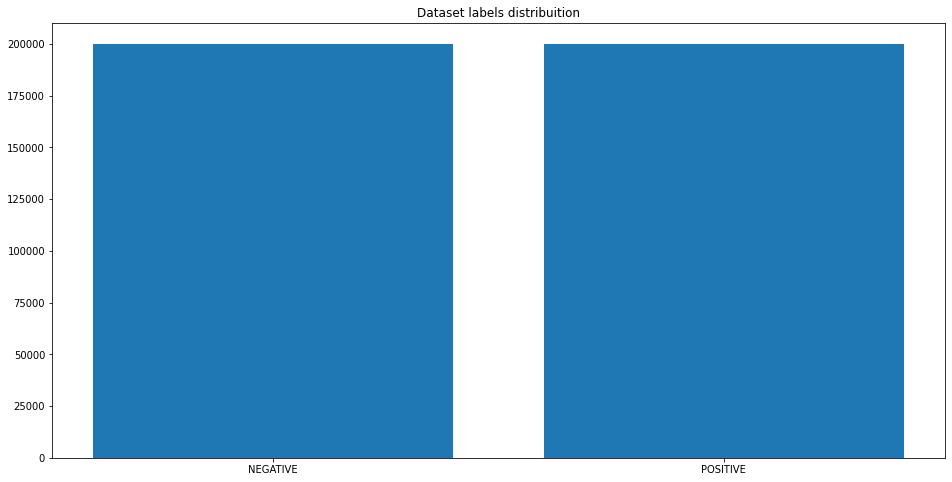

In [66]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Предобработка данных

In [67]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [149]:
def preprocess(text, stem=False):
    # Перевод текста в нижний регистр, удаление стоп-слов, тегов и спецсимволов с помощью регулярного выражения
    # TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [69]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 12.3 s


### Раздел на тренировочные и тестовые данные

In [70]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 320000
TEST size: 80000


### Word2Vec 

In [71]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 12.6 s


In [72]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec(vector_size = W2V_SIZE,
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2023-05-11 03:04:10,825 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-05-11T03:04:10.825739', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [73]:
w2v_model.build_vocab(documents)

2023-05-11 03:04:18,896 : INFO : collecting all words and their counts
2023-05-11 03:04:18,897 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-05-11 03:04:18,918 : INFO : PROGRESS: at sentence #10000, processed 72032 words, keeping 13791 word types
2023-05-11 03:04:18,944 : INFO : PROGRESS: at sentence #20000, processed 143911 words, keeping 21328 word types
2023-05-11 03:04:18,974 : INFO : PROGRESS: at sentence #30000, processed 215539 words, keeping 27583 word types
2023-05-11 03:04:18,994 : INFO : PROGRESS: at sentence #40000, processed 287220 words, keeping 32912 word types
2023-05-11 03:04:19,017 : INFO : PROGRESS: at sentence #50000, processed 359266 words, keeping 37730 word types
2023-05-11 03:04:19,035 : INFO : PROGRESS: at sentence #60000, processed 432144 words, keeping 42166 word types
2023-05-11 03:04:19,062 : INFO : PROGRESS: at sentence #70000, processed 505131 words, keeping 46341 word types
2023-05-11 03:04:19,095 : INFO : PROGRESS: at s

In [76]:
words = w2v_model.wv
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 13400


In [77]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-05-11 03:05:43,053 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 13400 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-05-11T03:05:43.053402', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2023-05-11 03:05:44,151 : INFO : EPOCH 0 - PROGRESS: at 84.49% examples, 1637213 words/s, in_qsize 14, out_qsize 1
2023-05-11 03:05:44,305 : INFO : EPOCH 0: training on 2308778 raw words (1974905 effective words) took 1.2s, 1684480 effective words/s
2023-05-11 03:05:45,329 : INFO : EPOCH 1 - PROGRESS: at 77.11% examples, 1517265 words/s, in_qsize 12, out_qsize 3
2023-05-11 03:05:45,573 : INFO : EPOCH 1: training on 2308778 raw words (1974818 effective words) took 1.2s, 1581481 effective words/s
2023-05-11 03:05:46,607 : INFO : EPOCH 2 - PROGRESS: at 85.79% examples, 1687463 words/s, in_q

2023-05-11 03:06:30,274 : INFO : EPOCH 31 - PROGRESS: at 62.81% examples, 1216148 words/s, in_qsize 14, out_qsize 1
2023-05-11 03:06:30,789 : INFO : EPOCH 31: training on 2308778 raw words (1975204 effective words) took 1.5s, 1291678 effective words/s
2023-05-11 03:06:30,789 : INFO : Word2Vec lifecycle event {'msg': 'training on 73880896 raw words (63201837 effective words) took 47.7s, 1324115 effective words/s', 'datetime': '2023-05-11T03:06:30.789847', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}


Wall time: 47.7 s


(63201837, 73880896)

In [78]:
w2v_model.wv.most_similar("love")

[('loves', 0.6169880628585815),
 ('luv', 0.5865406394004822),
 ('loved', 0.5741199254989624),
 ('amazing', 0.5699005126953125),
 ('adore', 0.5637962818145752),
 ('lovee', 0.5291818976402283),
 ('loooove', 0.5174007415771484),
 ('duet', 0.5119617581367493),
 ('awesome', 0.4815954864025116),
 ('selenagomez', 0.4807559847831726)]

### Токенизация текста

In [79]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 120031
Wall time: 4.23 s


In [80]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

80000

### Кодировка целевой переменной

In [81]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [82]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (320000, 1)
y_test (80000, 1)


In [156]:
y_train[5]

array([1])

In [83]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (320000, 300)
y_train (320000, 1)

x_test (80000, 300)
y_test (80000, 1)


In [84]:
y_train[:10]

array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1]])

### Создание слоя эмбеддинга

In [87]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(120031, 100)


In [88]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Создание LSTM модели

In [105]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(25, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          12003100  
                                                                 
 dropout_6 (Dropout)         (None, 300, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 25)                12600     
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 12,015,726
Trainable params: 12,626
Non-trainable params: 12,003,100
_________________________________________________________________


### Компиляция модели

In [106]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Обратные вызовы

In [107]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Обучение

In [108]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
282/282 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7211WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 04:19:28,945 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2596s 9s/step - loss: 0.5472 - accuracy: 0.7211 - val_loss: 0.4970 - val_accuracy: 0.7582 - lr: 0.0010
Epoch 2/8
282/282 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.7473WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 05:01:50,615 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2542s 9s/step - loss: 0.5106 - accuracy: 0.7473 - val_loss: 0.4861 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 3/8
282/282 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7532WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 05:44:04,595 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2534s 9s/step - loss: 0.5004 - accuracy: 0.7532 - val_loss: 0.4804 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 4/8
282/282 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.7561WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 06:26:18,510 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2534s 9s/step - loss: 0.4952 - accuracy: 0.7561 - val_loss: 0.4771 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 5/8
282/282 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.7593WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 07:08:23,769 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2525s 9s/step - loss: 0.4910 - accuracy: 0.7593 - val_loss: 0.4740 - val_accuracy: 0.7701 - lr: 0.0010
Epoch 6/8
282/282 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.7609WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 07:50:11,725 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2508s 9s/step - loss: 0.4887 - accuracy: 0.7609 - val_loss: 0.4722 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 7/8
282/282 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.7635WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 08:31:58,252 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2507s 9s/step - loss: 0.4856 - accuracy: 0.7635 - val_loss: 0.4715 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 8/8
282/282 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7632WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-05-11 09:13:43,502 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 2505s 9s/step - loss: 0.4846 - accuracy: 0.7632 - val_loss: 0.4693 - val_accuracy: 0.7735 - lr: 0.0010
Wall time: 5h 37min 31s


### Оценка

In [109]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

79/79 [==============================] - 53s 669ms/step - loss: 0.4695 - accuracy: 0.7747

ACCURACY: 0.7746875286102295
LOSS: 0.46946629881858826
Wall time: 54.7 s


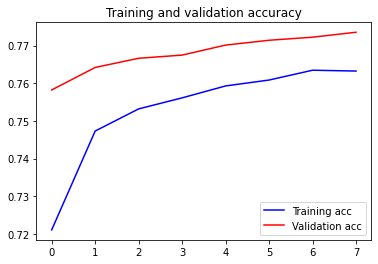

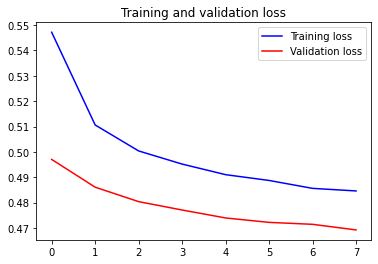

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Предсказание

In [113]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [114]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Токенизируем текст, переданный в функцию
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Обращаемся к модели
    score = model.predict([x_test])[0]
    # Получаем решение по входному тексту
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [115]:
predict("I love the music")

1/1 [==============================] - 0s 491ms/step


{'label': 'POSITIVE',
 'score': 0.9702490568161011,
 'elapsed_time': 0.5892667770385742}

In [116]:
predict("I hate the rain")

1/1 [==============================] - 0s 45ms/step


{'label': 'NEGATIVE',
 'score': 0.018098624423146248,
 'elapsed_time': 0.08788704872131348}

In [117]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 35ms/step


{'label': 'NEUTRAL',
 'score': 0.4369674026966095,
 'elapsed_time': 0.09511041641235352}

### Confusion Matrix

In [257]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

10/10 [==============================] - 44s 4s/step
Wall time: 44.4 s


In [258]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

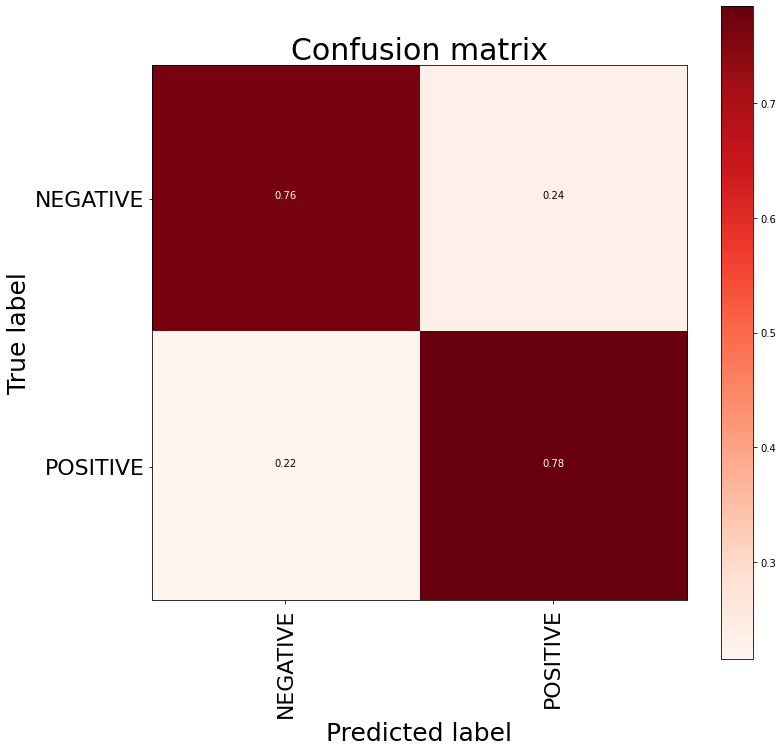

Wall time: 612 ms


In [259]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [121]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.76      0.77     40012
    POSITIVE       0.77      0.78      0.78     39988

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000



### Accuracy Score

In [122]:
accuracy_score(y_test_1d, y_pred_1d)

0.7746875

### Save model

In [123]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2023-05-11 11:56:27,223 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-11T11:56:27.223876', 'gensim': '4.3.1', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2023-05-11 11:56:27,239 : INFO : not storing attribute cum_table
2023-05-11 11:56:27,958 : INFO : saved model.w2v


In [124]:
from keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

# Создание модели
model_cnn = Sequential()

# Добавление слоя эмбеддинга
model_cnn.add(embedding_layer)

# Добавление слоя Dropout
model_cnn.add(Dropout(0.5))

# Добавление сверточных слоев
model_cnn.add(Conv1D(128, 5, activation='relu'))  # 128 фильтров, размер окна 5
model_cnn.add(Conv1D(64, 5, activation='relu'))   # 64 фильтра, размер окна 5

# Добавление слоя глобального пулинга
model_cnn.add(GlobalMaxPooling1D())

# Добавление полносвязного слоя
model_cnn.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [125]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [126]:
%%time
history_cnn = model_cnn.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
282/282 [==============================] - 516s 2s/step - loss: 0.5732 - accuracy: 0.6982 - val_loss: 0.5073 - val_accuracy: 0.7509 - lr: 0.0010
Epoch 2/8
282/282 [==============================] - 519s 2s/step - loss: 0.5368 - accuracy: 0.7257 - val_loss: 0.4985 - val_accuracy: 0.7582 - lr: 0.0010
Epoch 3/8
282/282 [==============================] - 526s 2s/step - loss: 0.5267 - accuracy: 0.7334 - val_loss: 0.4944 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 4/8
282/282 [==============================] - 529s 2s/step - loss: 0.5210 - accuracy: 0.7373 - val_loss: 0.4902 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 5/8
282/282 [==============================] - 515s 2s/step - loss: 0.5167 - accuracy: 0.7407 - val_loss: 0.4895 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 6/8
282/282 [==============================] - 587s 2s/step - loss: 0.5122 - accuracy: 0.7437 - val_loss: 0.4832 - val_accuracy: 0.7645 - lr: 0.0010
Epoch 7/8
282/282 [==============================] - 542s 2s/step - lo

In [128]:
%%time
# Оценивание

score = model_cnn.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

79/79 [==============================] - 35s 438ms/step - loss: 0.4812 - accuracy: 0.7656

ACCURACY: 0.7655624747276306
LOSS: 0.48115274310112
Wall time: 35 s


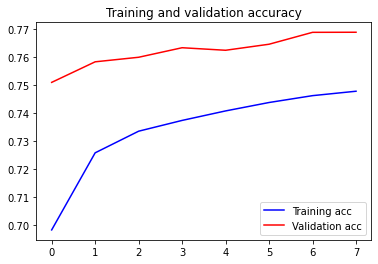

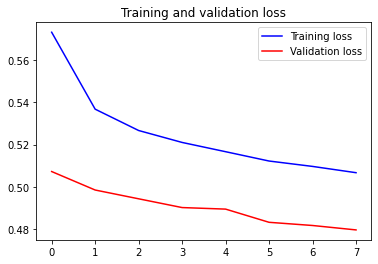

In [129]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [131]:
def predict_cnn(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model_cnn.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [132]:
predict_cnn("I adore rabbits")

1/1 [==============================] - 1s 511ms/step


{'label': 'POSITIVE',
 'score': 0.8685786724090576,
 'elapsed_time': 0.6072733402252197}

In [147]:
predict_cnn("I am in pain")

1/1 [==============================] - 0s 27ms/step


{'label': 'NEGATIVE',
 'score': 0.04263010993599892,
 'elapsed_time': 0.09410572052001953}

In [148]:
predict_cnn("I am Oleg Kazmin")

1/1 [==============================] - 0s 38ms/step


{'label': 'NEUTRAL',
 'score': 0.562647819519043,
 'elapsed_time': 0.09302544593811035}

In [141]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model_cnn.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

10/10 [==============================] - 40s 4s/step


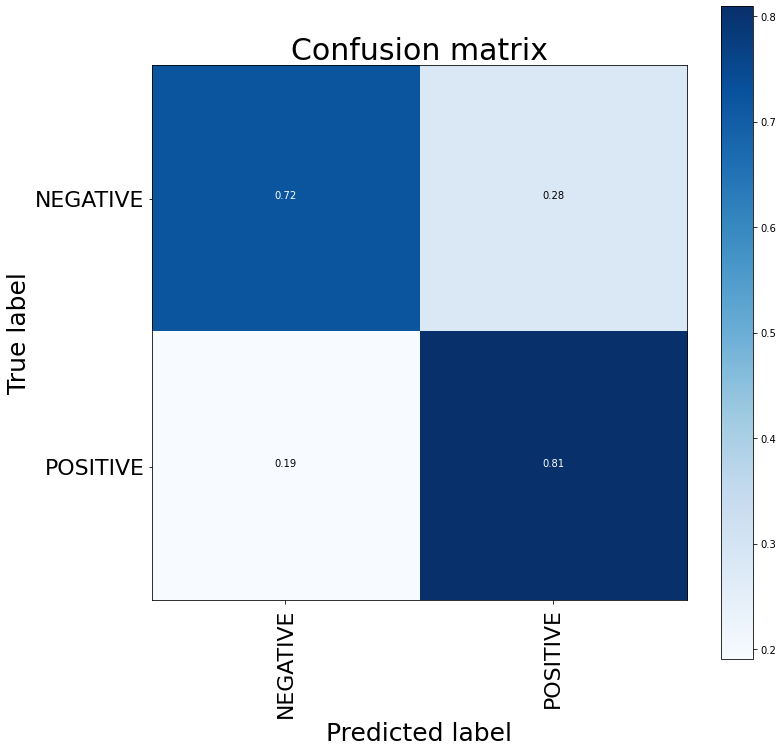

In [142]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [143]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.72      0.75     40012
    POSITIVE       0.74      0.81      0.78     39988

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000



In [144]:
accuracy_score(y_test_1d, y_pred_1d)

0.7655625

In [250]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [264]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 120031


In [273]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
print(x_train.shape)
print(x_test.shape)

(320000, 300)
(80000, 300)


In [274]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (320000,)
y_test (80000,)


In [275]:
from sklearn.linear_model import LogisticRegression

# Инициализация модели
lr_model = LogisticRegression(solver='lbfgs', max_iter = 320000)

# Обучение модели на тренировочных данных
lr_model.fit(x_train, y_train)

# Предсказание на тестовых данных
y_pred_lr = lr_model.predict(x_test)

# Оценка качества модели
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy score (Logistic Regression): {:.3f}".format(accuracy_lr))

Accuracy score (Logistic Regression): 0.501


In [277]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Вычисление метрик precision, recall и F1
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))

Precision: 0.500
Recall: 0.963
F1 Score: 0.659
